# testing file 4

## transformers

We want to see if we can fine tune locally, also see hwo to structure data for gpt4 training, maybe embeddings, maybe model

In [1]:
import os
os.getcwd()

'/home/sat4017/PRIME'

In [2]:
#download the model

from transformers import GPT2Model, GPT2Tokenizer

# Specify which size of GPT-2 you want: 'gpt2-small', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'
model_name = 'gpt2-medium'

# Download the model and tokenizer
model = GPT2Model.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Save the model and tokenizer locally
model.save_pretrained('saved_models/gpt2-medium/')
tokenizer.save_pretrained('saved_models/gpt2-medium/')


/home/sat4017/miniforge3/envs/prot_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('saved_models/gpt2-medium/tokenizer_config.json',
 'saved_models/gpt2-medium/special_tokens_map.json',
 'saved_models/gpt2-medium/vocab.json',
 'saved_models/gpt2-medium/merges.txt',
 'saved_models/gpt2-medium/added_tokens.json')

In [3]:
#just test the model

from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
# Load the tokenizer and the model:
# python
# Copy code
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
# Prepare your input and get its tokenized version:
# python
# Copy code
input_text = "Once upon a time"
input_ids = tokenizer.encode(input_text, return_tensors="pt")
# Use the model to get the prediction:
# python
# Copy code
with torch.no_grad():
    output = model(input_ids)
    predictions = output.logits
# Decode the predicted token to get the continuation of the input text:
# python
# Copy code
predicted_token = torch.argmax(predictions[..., -1, :]).item()
predicted_text = tokenizer.decode([predicted_token])
print(f"Input Text: {input_text}")
print(f"Predicted continuation: {predicted_text}")

Input Text: Once upon a time
Predicted continuation: ,


In [4]:
#longer output
model.eval()
with torch.no_grad():
    for _ in range(10):
        output = model(input_ids)
        predictions = output.logits
        predicted_token = torch.argmax(predictions[..., -1, :]).item()
        input_ids = torch.cat([input_ids, torch.tensor([[predicted_token]])], dim=1)
generated_text = tokenizer.decode(input_ids[0])
print(f"Input Text: {input_text}")
print(f"Generated Text: {generated_text}")


Input Text: Once upon a time
Generated Text: Once upon a time, the world was a place of great beauty and


In [ ]:
#we will now try to fine tune

## basic data viewing

In [1]:
#need to see how data is after knn imputation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error

dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)

Seed set to 42


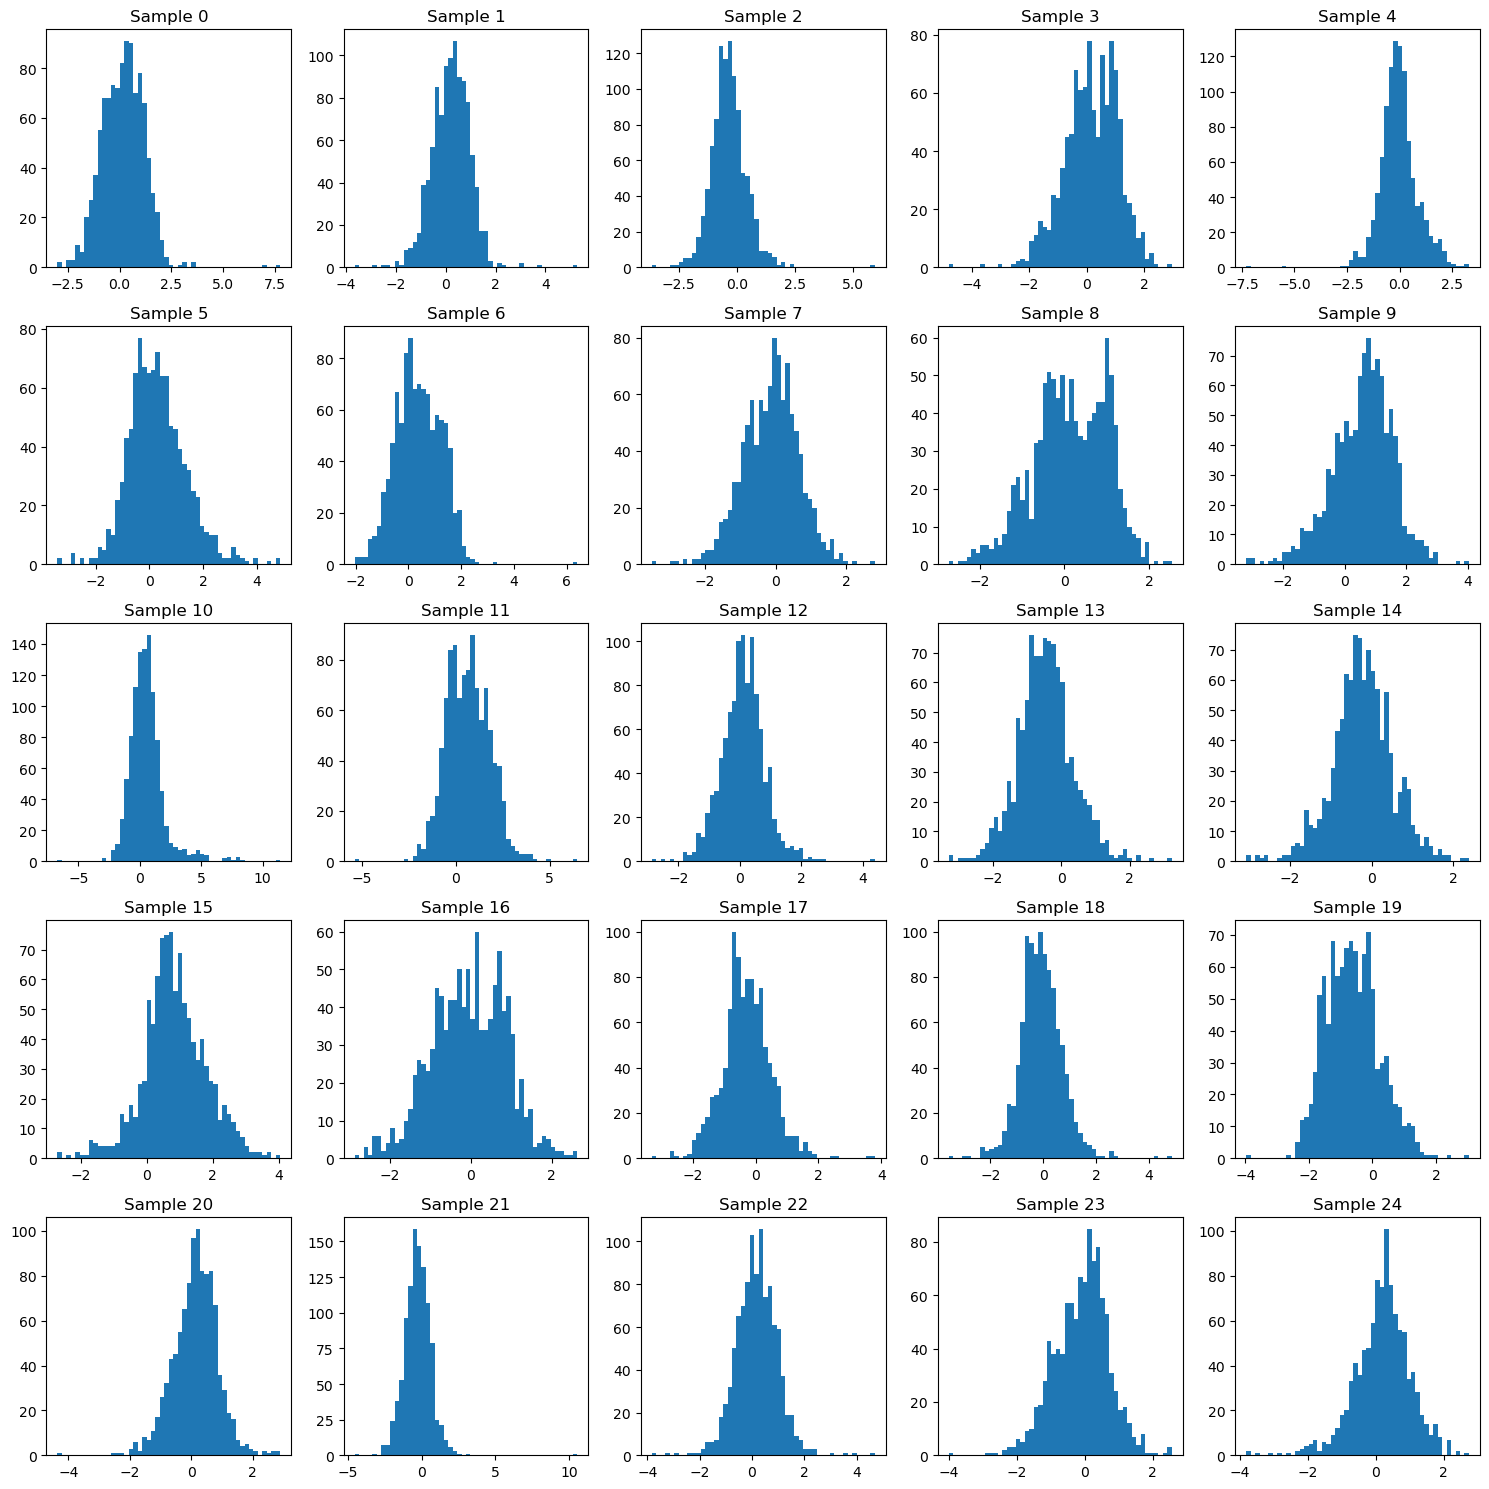

In [7]:
#let's just plot some of them
#a 5 x 5 subplot
fig, axs = plt.subplots(5,5,figsize=(15,15))
for i in range(5):
    for j in range(5):
        axs[i,j].hist(cv.prot[i*5+j,:], bins=50)
        axs[i,j].set_title('Sample '+str(i*5+j))
        
plt.tight_layout()
plt.show()

# add patient data

In [4]:
#now let's stratify it by sex, and we will load it in properly and then save it out so we store the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error

dataloader = LoadData(impute='KNN',load = False)

Seed set to 42


In [6]:
print(dataloader.patient_ids.shape)
print(dataloader.patient_ids[0:10])

(25818,)
[1000072 1000256 1000364 1000700 1000793 1000834 1001213 1001224 1001339
 1001734]


In [8]:
#and just save it all outu so can load in the future
dataloader.savefile('m_knn','p_knn','p_cols')

In [9]:
#and test again
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error

dataloader = LoadData(impute='KNN',load = True)
print(dataloader.patient_ids.shape)

Seed set to 42


(25818,)


In [5]:
#now we will load in the demographic data
#use PD to read it in
demographic_data = pd.read_csv('age_sex_bmi_all_ukbb_patients.csv')
demographic_data.head()

,Unnamed: 0,eid,31-0.0,21001-0.0,21003-0.0
0,0,2075783,0,23.3976,62
1,1,4345775,0,27.4844,63
2,2,5686018,1,29.2593,65
3,3,3907457,0,24.1672,50
4,4,3160513,1,29.7650,63


In [10]:
demographic_dict = demographic_data.set_index('eid')[['31-0.0', '21001-0.0', '21003-0.0']].to_dict(orient='index')

# Converting dictionary values from dicts to lists
demographic_dict = {k: list(v.values()) for k, v in demographic_dict.items()}

In [11]:
demographic_dict[2075783]

[0, 23.3976, 62]

In [13]:
#save the dict as a json
import json
with open('/home/sat4017/PRIME/saved_data/demographic_dict.json', 'w') as fp:
    json.dump(demographic_dict, fp)

In [1]:
#retry it again
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
# import torch
# import torch.nn as nn
# import pytorch_lightning as pl
# from pytorch_lightning import seed_everything

# seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error

dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)
cv.demo_dict

{2075783: [0, 23.3976, 62],
 4345775: [0, 27.4844, 63],
 5686018: [1, 29.2593, 65],
 3907457: [0, 24.1672, 50],
 3160513: [1, 29.765, 63],
 2565619: [0, 29.9673, 47],
 1574082: [0, 41.9141, 55],
 2672009: [0, 29.9974, 48],
 5347950: [1, 25.3426, 67],
 1975697: [0, 44.9137, 47],
 1797967: [1, 26.897, 69],
 5218739: [1, 37.8138, 64],
 4913736: [0, 25.2622, 41],
 4239032: [0, 32.5991, 59],
 3016561: [0, 25.6015, 56],
 5330786: [1, 20.2865, 48],
 4143332: [0, 35.0295, 61],
 2315717: [1, 36.7882, 41],
 2148655: [0, 35.1067, 63],
 3640462: [0, 24.0892, 45],
 5868903: [1, 23.3556, 69],
 3910333: [0, 25.9701, 63],
 2370809: [0, 28.2334, 58],
 4355477: [1, 22.6627, 69],
 2840264: [0, 23.3046, 50],
 5130146: [1, 28.2822, 52],
 4671532: [0, 24.1672, 67],
 3803771: [1, 32.3168, 67],
 4397105: [0, 22.546, 45],
 2959607: [0, 20.3997, 49],
 2599689: [0, 32.8576, 50],
 1046542: [0, 23.2426, 64],
 4412138: [1, 20.848000000000003, 49],
 5649227: [1, 29.3057, 61],
 5461731: [1, 28.0998, 69],
 3803839: [0

In [3]:
demo_vec = cv.demographic_vec('sex')
print(demo_vec.shape)
print(demo_vec) #very quick almost instant!

(25818,)
[1. 0. 1. ... 0. 1. 0.]


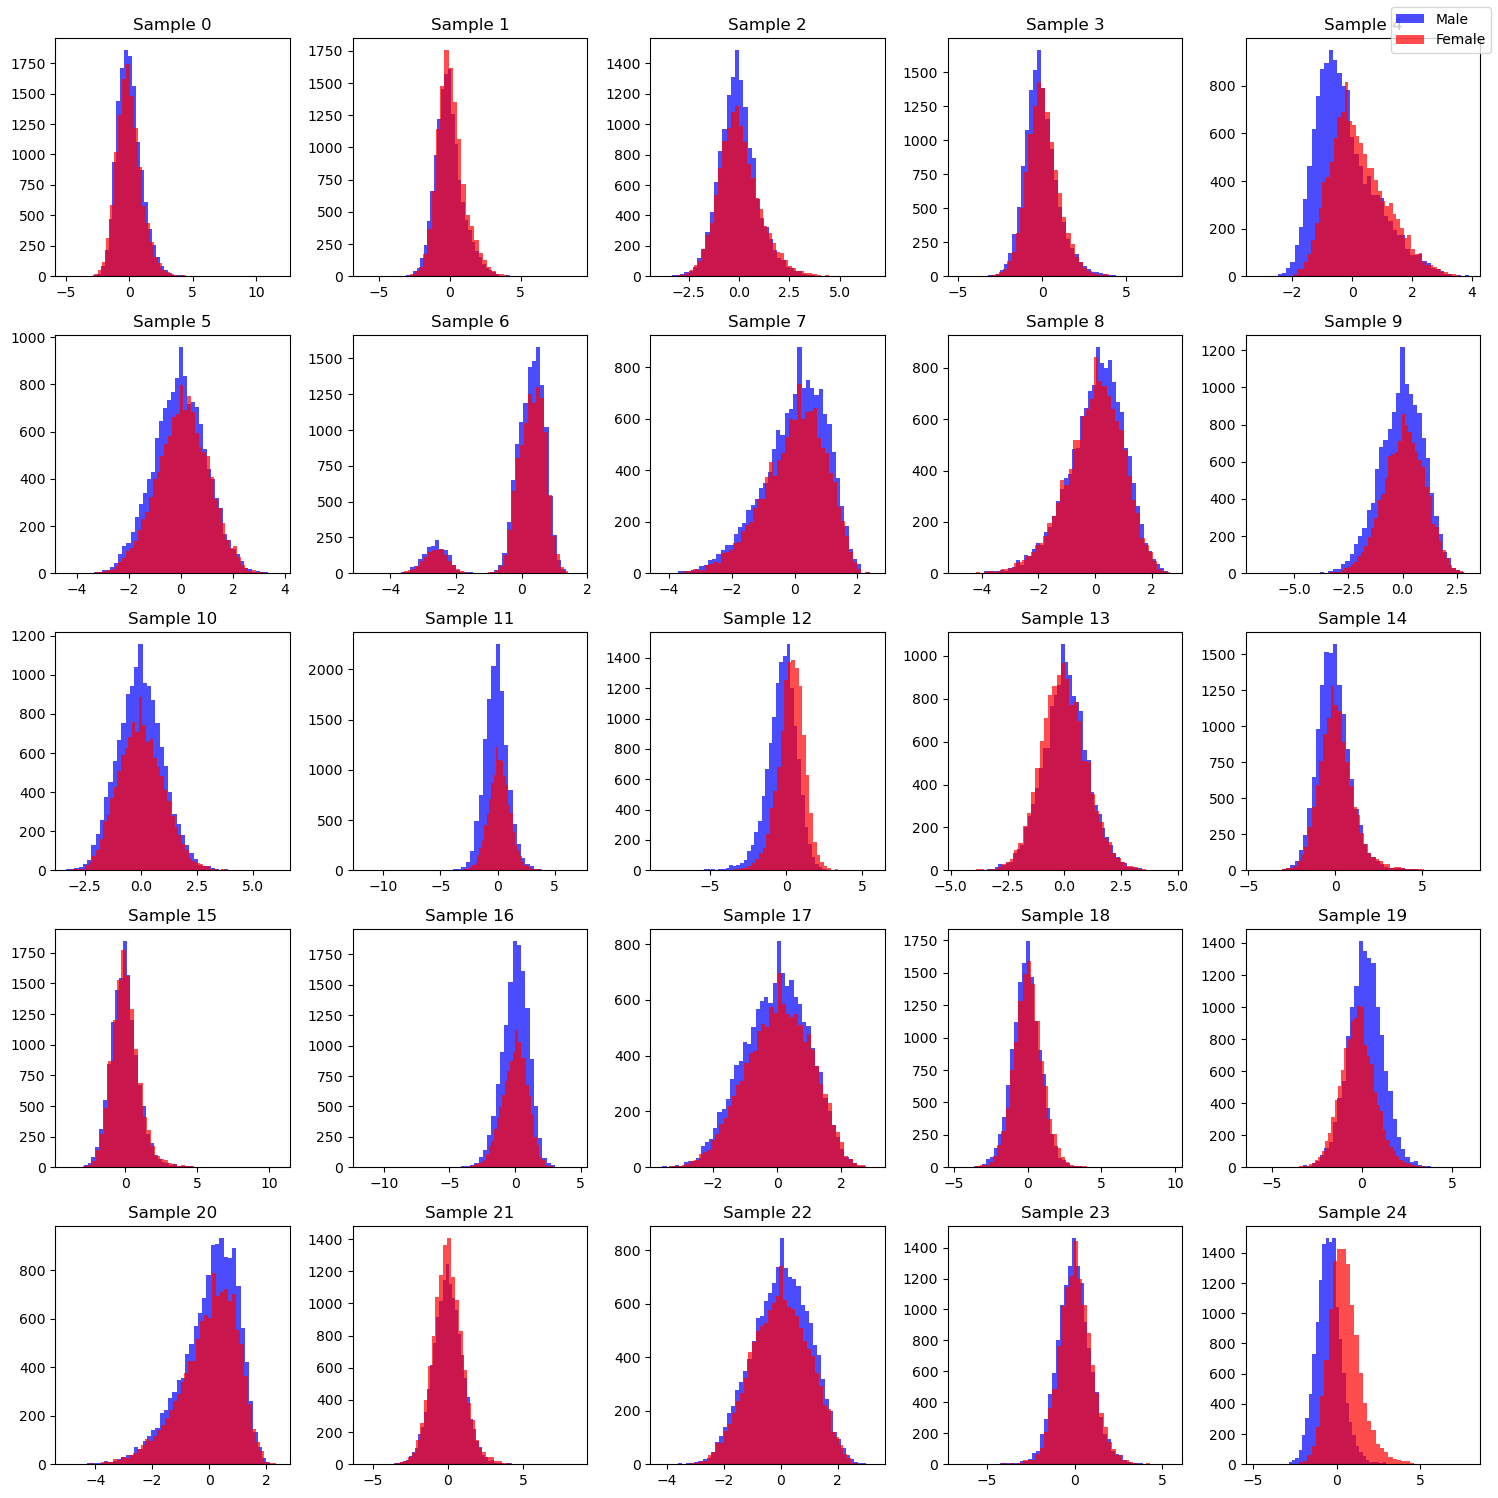

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming cv.prot is your data array and cv.sex is the binary variable for sex
# For demonstration, I'll create a sample data array and a binary sex array
# cv = {'prot': np.random.rand(25, 100), 'sex': np.random.randint(0, 2, 25)}  # Example data, replace with your actual data

fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # Create a 5x5 grid of subplots

for i in range(5):
    for j in range(5):
        index = i*5+j
        patient_id = cv.patient_ids[index]
        #wait this is complicated, need to find the sex for each individual patient, then we can do it, this is hard, will do tonight
        data_male = cv.prot[demo_vec == 0, index]  # Data for males
        data_female = cv.prot[demo_vec == 1, index]  # Data for females

        axs[i, j].hist(data_male, color='blue', alpha=0.7, label='Male', bins=50)
        axs[i, j].hist(data_female, color='red', alpha=0.7, label='Female', bins=50)
        axs[i, j].set_title('Sample ' + str(index))

plt.tight_layout()  # Adjust layout
fig.legend(['Male', 'Female'])  # Add legend for the entire figure
plt.show()  # Display the plot

#don't actually know male vs female, just know whhat it is

In [7]:
#debugging

cv.demo_dict[patient_id][0]

1

# our own network that has transformer block/embedding

In [1]:
#retry it again
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
# import torch
# import torch.nn as nn
# import pytorch_lightning as pl
# from pytorch_lightning import seed_everything

# seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error

dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)

In [20]:
#this is the skeleton of the model, but it may work for evaluation



class GPT2ForRegression(nn.Module):
    def __init__(self, num_metabolites, num_proteins):
        super(GPT2ForRegression, self).__init__()
        self.gpt2 = GPT2Model.from_pretrained('/home/sat4017/PRIME/saved_models/gpt2-medium/')
        # Assuming each metabolite is represented by a single embedding vector
        self.metabolite_embedding = nn.Linear(num_metabolites, self.gpt2.config.n_embd) #251 -> 1024
        # A linear layer to transform the output of GPT-2 to predict protein values
        self.regression_head = nn.Linear(self.gpt2.config.n_embd, num_proteins) #1024 -> 1039

    def forward(self, metabolite_data):
        # Embedding the metabolite data
        embedded_metabolites = self.metabolite_embedding(metabolite_data)
        # Pass through GPT-2
        gpt2_output = self.gpt2(inputs_embeds=embedded_metabolites)
        # Only take the output from the last token for regression
        print(gpt2_output.last_hidden_state.shape)
        last_token_output = gpt2_output.last_hidden_state#[:, -1, :] unsure why there's no sequence length value. Maybe since only asking for 1?
        # Predict protein values
        protein_predictions = self.regression_head(last_token_output)
        return protein_predictions

from transformers import GPT2Model, GPT2Tokenizer

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming cv.met and cv.prot are numpy arrays or tensors
testx = torch.tensor(cv.met[:2,:], dtype=torch.float32).to(device)
testy = torch.tensor(cv.prot[:2,:], dtype=torch.float32).to(device)

# Initialize the model
module = GPT2ForRegression(num_metabolites=testx.shape[1], num_proteins=testy.shape[1])
module.to(device)

# Model Inference
output = module(testx)

# To compare the output with testy, you may need to apply any necessary post-processing
# For example, if testy is a vector of protein concentrations
predicted_proteins = output  # Remove batch dimension

# You can then compare 'predicted_proteins' with 'testy' to see the model's performance
print(predicted_proteins.shape)

torch.Size([2, 1024])
torch.Size([2, 1039])


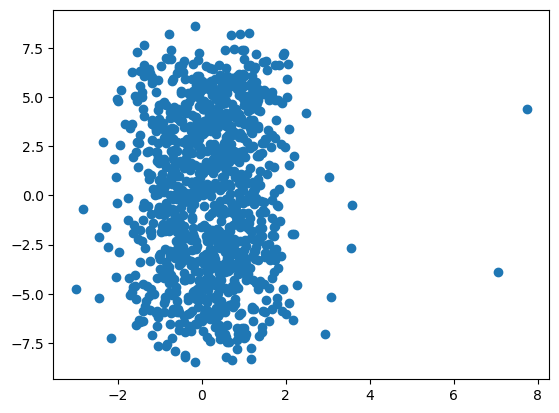

In [24]:
#let's see how terrible this prediction is

#just plot actual on x axis and predicted on y axis
plt.scatter(testy[0,:].cpu().detach(),predicted_proteins[0,:].cpu().detach())

In [9]:
#the fundamental issue of this approach is that we are actually treating it as a single sequence and then taking a single output
#doesn't use the sequence at all, so it's not really a good approach, no self attention

#soo the input into gpt2, when we input a matrix of size 2 x 100 and in this case each of the 100 is turned into 1024\
#does it just think that there are 2 embedded tokens being input?

#yes that is completely correct, each one should be a value, then it needs to keep predicting out 1024 times, clealry this too big of a context length
#the context will end up being 251 + 1023 at max which is rather high lol. It's fine tho, we'll figure it out later

251

# redo it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
# import torch
# import torch.nn as nn
# import pytorch_lightning as pl
# from pytorch_lightning import seed_everything

# seed_everything(42)


from utils import *
from sklearn.metrics import mean_squared_error
from transformers import GPT2Model, GPT2Tokenizer

dataloader = LoadData(impute='KNN',load = True)
cv = CV(dataloader)

In [ ]:
#alternate approach

class GPT2ForRegression(nn.Module):
    def __init__(self, num_metabolites, num_proteins):
        super(GPT2ForRegression, self).__init__()
        self.gpt2 = GPT2Model.from_pretrained('/home/sat4017/PRIME/saved_models/gpt2-medium/')
        # Assuming each metabolite is represented by a single embedding vector
        self.metabolite_embedding = nn.Linear(num_metabolites, self.gpt2.config.n_embd) #251 -> 1024
        # A linear layer to transform the output of GPT-2 to predict protein values
        self.regression_head = nn.Linear(self.gpt2.config.n_embd, num_proteins) #1024 -> 1039

    def forward(self, metabolite_data):
        # Embedding the metabolite data
        embedded_metabolites = self.metabolite_embedding(metabolite_data)
        # Pass through GPT-2
        gpt2_output = self.gpt2(inputs_embeds=embedded_metabolites)
        # Only take the output from the last token for regression
        print(gpt2_output.last_hidden_state.shape)
        last_token_output = gpt2_output.last_hidden_state#[:, -1, :] unsure why there's no sequence length value. Maybe since only asking for 1?
        # Predict protein values
        protein_predictions = self.regression_head(last_token_output)
        return protein_predictions



In [2]:
#so let's try this now, where we first will get the tokenizer and see how it works
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#now see what tokenizer is shaped like
tokenizer
#max model length says that can handl up to 1024?  Yes, that is true!
#the tokenizer is also pretty logical

GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
#now we can loop through it and get some tokenized output...

